In [1]:
from ridge_regression import RidgeRegression, plot_prediction_functions, compare_parameter_vectors
import setup_problem
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
lasso_data_fname = "lasso_data.pickle"
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = setup_problem.load_problem(lasso_data_fname)
X_train = featurize(x_train)
X_val = featurize(x_val)
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))
val_fold = [-1]*len(X_train) + [0]*len(X_val)

param_grid = [{'l2reg':np.concatenate((10.**np.arange(-3, 1, 0.5), np.arange(1,3,0.3))) }]

ridge_regression_estimator = RidgeRegression()
grid = GridSearchCV(ridge_regression_estimator,
                        param_grid,
                        return_train_score=False,
                        cv = PredefinedSplit(test_fold=val_fold),
                        refit = True,
                        scoring = make_scorer(mean_squared_error,
                                              greater_is_better = False))
grid.fit(X_train_val, y_train_val)
df = pd.DataFrame(grid.cv_results_)
df['mean_test_score'] = -df['mean_test_score']
cols_to_keep = ["param_l2reg", "mean_test_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow = df_toshow.sort_values(by=["param_l2reg"])
df_toshow

,param_l2reg,mean_test_score
0,0.001000,0.162705
1,0.003162,0.151900
2,0.010000,0.141887
3,0.031623,0.139648
4,0.100000,0.144566
5,0.316228,0.152607
6,1.000000,0.171068
8,1.000000,0.171068
9,1.300000,0.179521
10,1.600000,0.187993


/Users/cyian/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


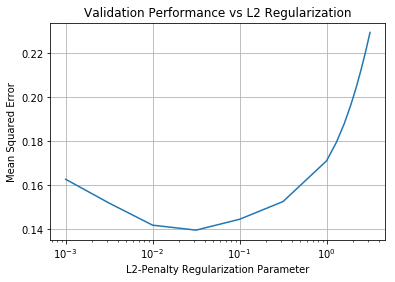

In [3]:
fig, ax = plt.subplots()
ax.semilogx(df_toshow["param_l2reg"], df_toshow["mean_test_score"])
ax.grid()
ax.set_title("Validation Performance vs L2 Regularization")
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
fig.show()

In [4]:
para_final = df_toshow['param_l2reg'][np.argmin(df_toshow['mean_test_score'])]

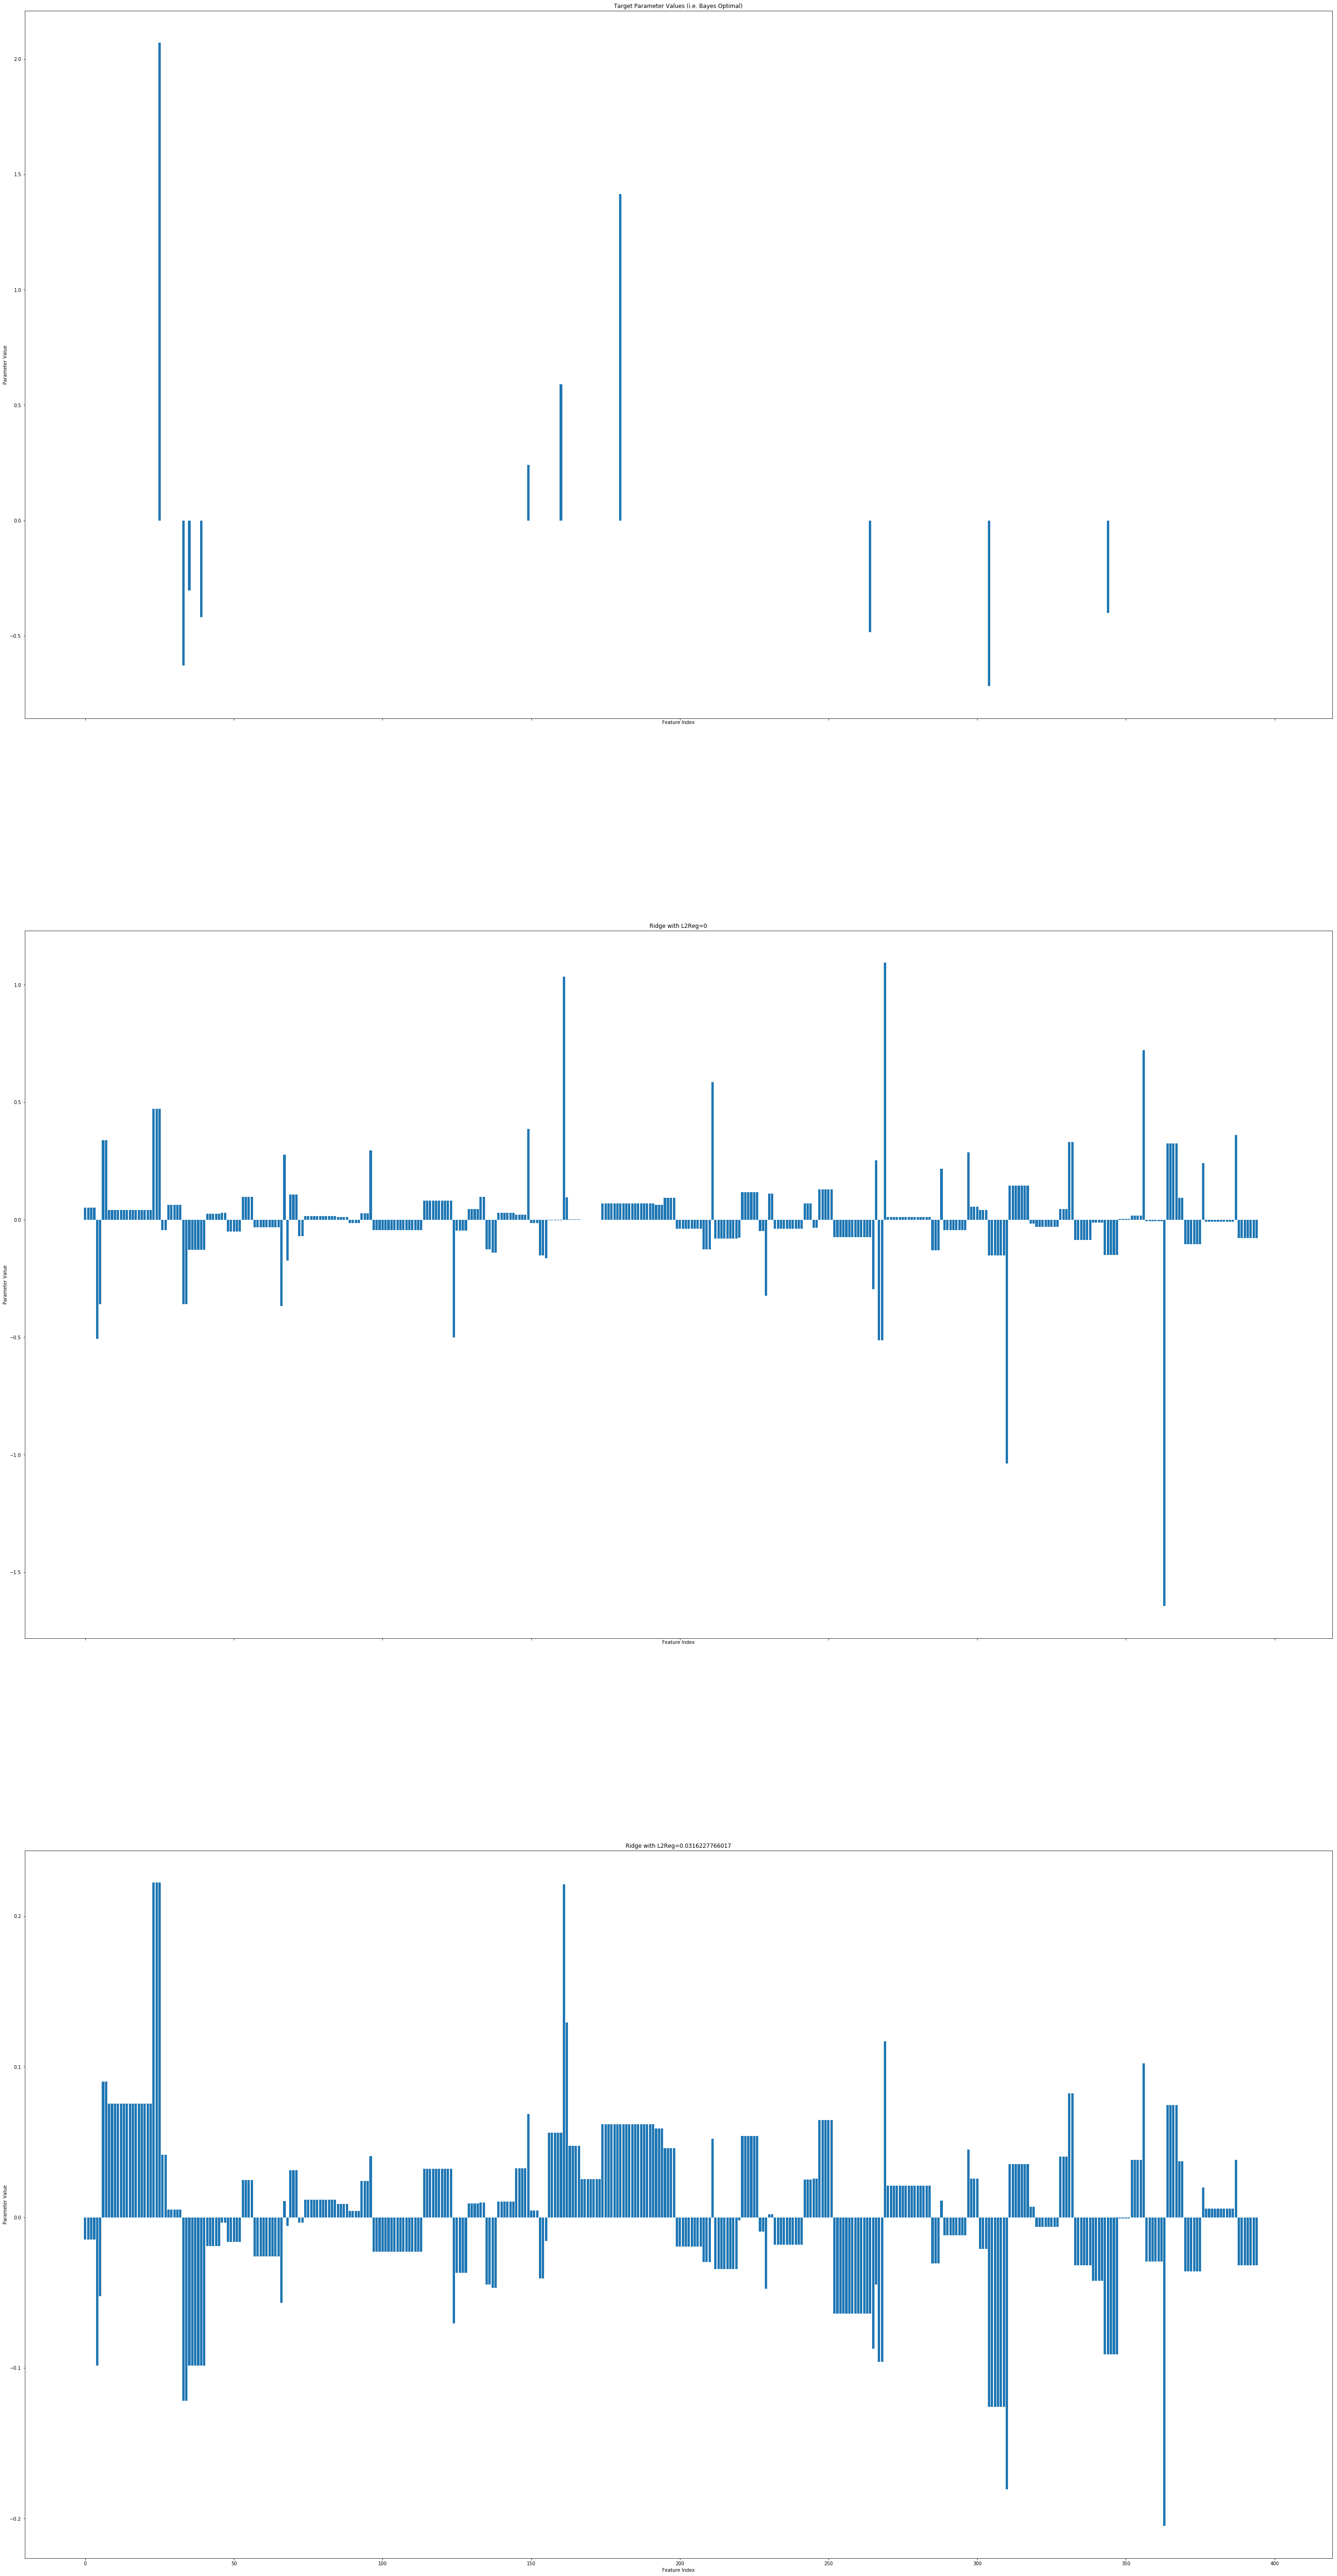

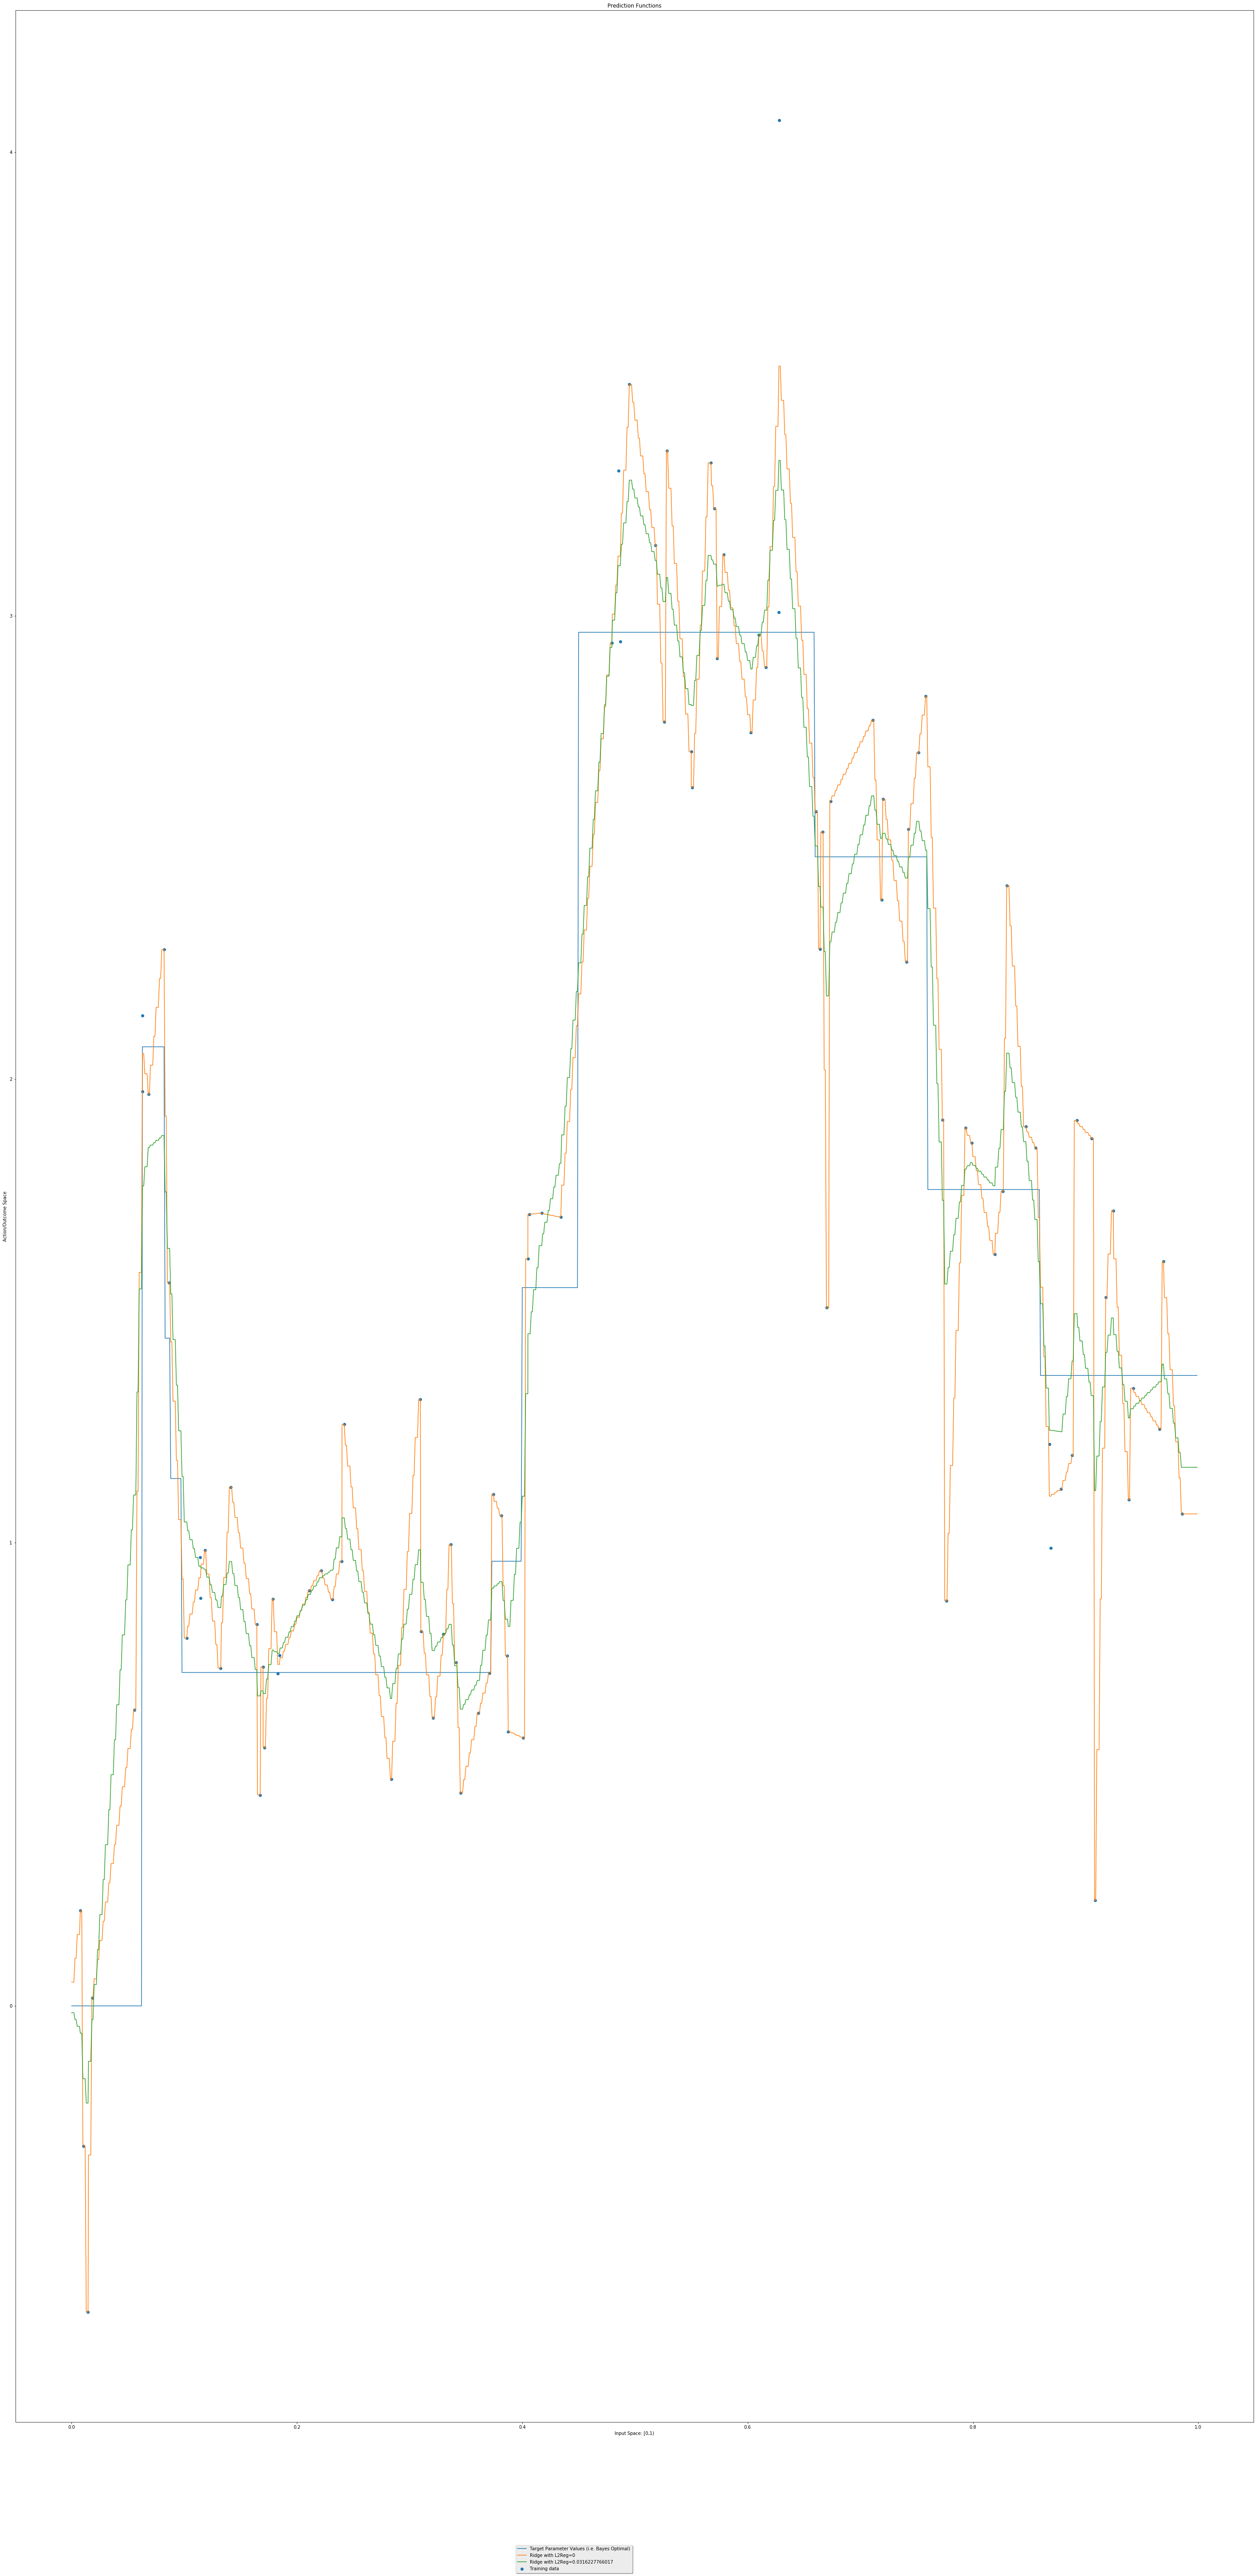

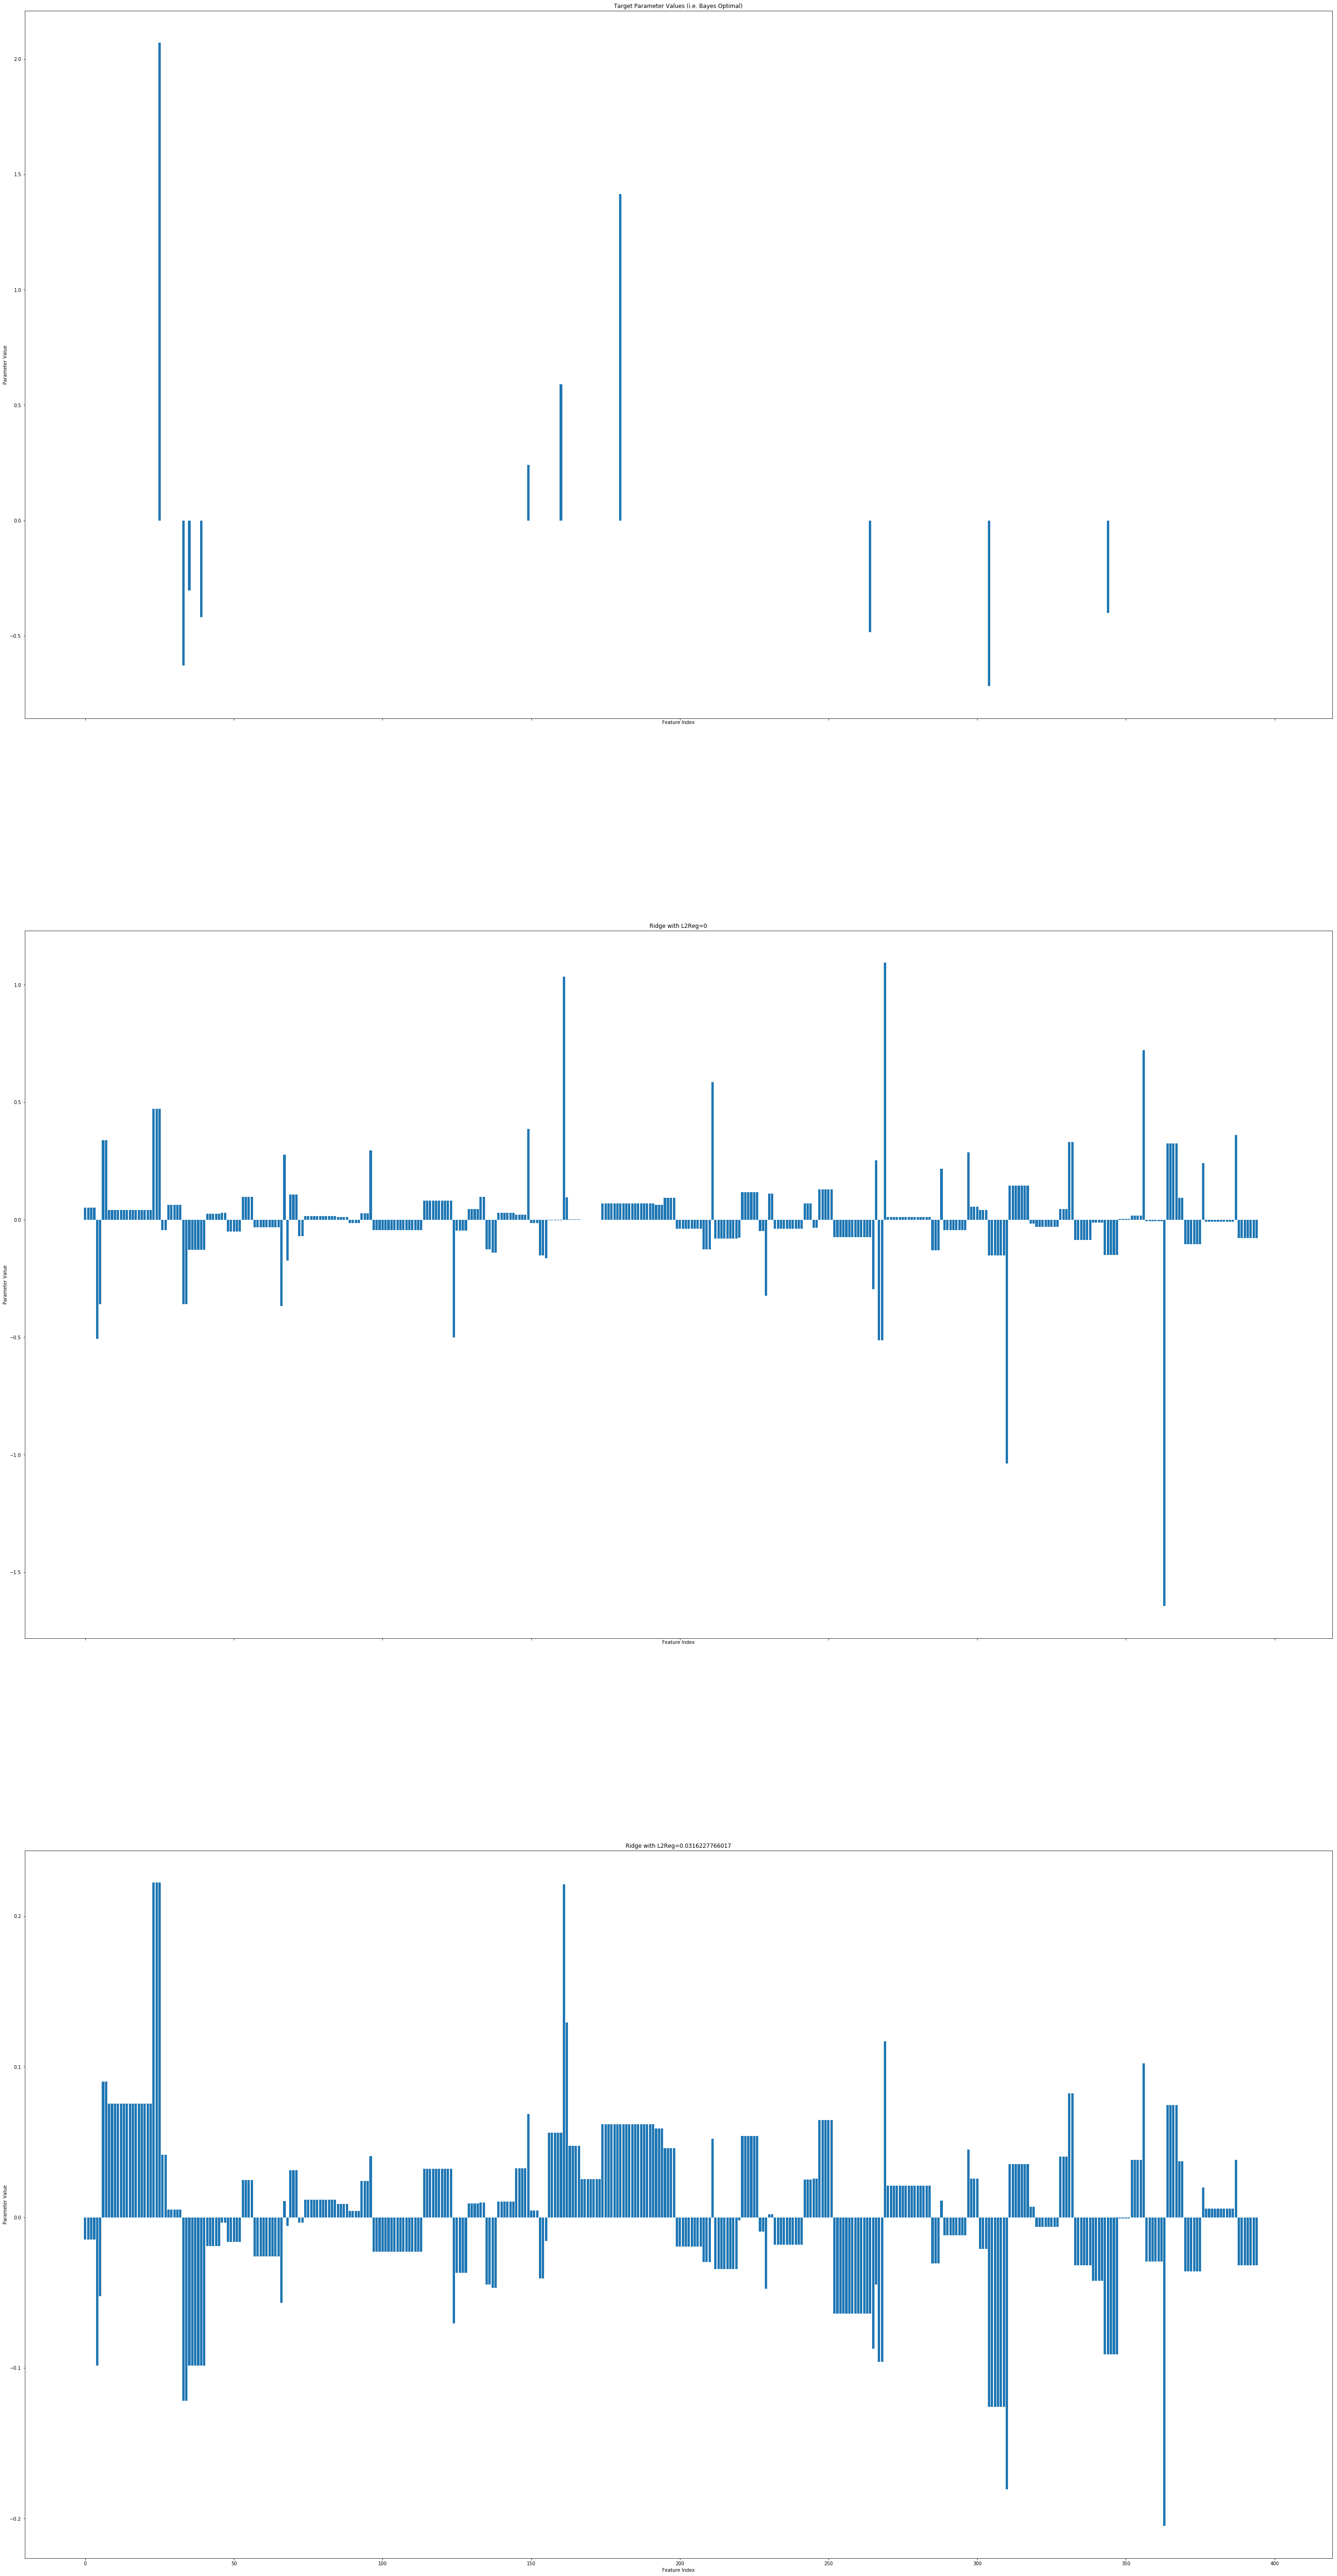

In [5]:
#2.2
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

l2regs = [0, para_final]
X = featurize(x)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name,
                    "coefs":ridge_regression_estimator.w_,
                    "preds": ridge_regression_estimator.predict(X) })

plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
compare_parameter_vectors(pred_fns)

In [6]:
max_ls = []
min_ls = [] 
max_idx_ls = []
for i in range(len(pred_fns)):
    max_ls.append(max(pred_fns[i]['coefs']))
    min_ls.append(min(pred_fns[i]['coefs']))
    max_idx_ls.append(np.argmax(pred_fns[i]['coefs']))

df_pred = pd.DataFrame(np.concatenate((max_ls, min_ls, max_idx_ls)).reshape(3,3), 
                       index = ['max', 'min', 'max index'],
                      columns = ['target', 'no regularization', 'best regularization'])

In [7]:
df_pred

,target,no regularization,best regularization
max,2.069572,1.093516,0.222279
min,-0.717818,-1.644220,-0.204951
max index,25.000000,269.000000,24.000000


In [8]:
any(pred_fns[2]['coefs']==0)

False

In [9]:
#2.3
from sklearn.metrics import confusion_matrix
threshold = [10**-6, 10**-3, 10**-2, 10**-1]
pred_fns[0]['coefs'][abs(pred_fns[0]['coefs']) > 0] = 1
target_coef = pred_fns[0]['coefs']
reg_coef = pred_fns[2]['coefs']
for i in threshold:
    copy_val = np.copy(reg_coef)
    copy_val[abs(reg_coef) >= i] = 1
    copy_val[abs(reg_coef) < i] = 0
    print(confusion_matrix(target_coef, copy_val))

[[  5 385]
 [  0  10]]
[[  9 381]
 [  0  10]]
[[ 61 329]
 [  0  10]]
[[376  14]
 [  7   3]]


In [37]:
#3.2
def soft(a, delta):
    if abs(a)- delta > 0:
        return np.sign(a)*(abs(a)-delta)
    else:
        return 0

def objective_function(X, y, w, lambd):
    y = y.reshape(-1)
    return np.sum((y-np.dot(X, w))**2) + lambd*sum(abs(i) for i in w)

def shooting_alg(X, y, w, lambd, iteration = 1000, tolerance = 10**-6):
    D = X.shape[1]
    criteria = 1
    count = 1
    while criteria > tolerance or count < iteration:
        obj_prev = objective_function(X, y, w, lambd)
        for j in range(D):
            aj = 2*np.dot(X[:,j], X[:,j])
            cj = 2*(np.dot(X[:,j],y) - np.dot(np.dot(X[:,j], X), w) 
                    + w[j]*np.dot(X[:,j],X[:,j]))
            wj = soft(cj/aj, lambd/aj)
            w[j] = wj
        criteria = obj_prev - objective_function(X,y,w, lambd)
        count += 1
    return w

In [38]:
w = np.zeros(X.shape[1])
w_cyc = shooting_alg(X_train, y_train, w, 1)

/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


In [39]:
w_cyc

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.70371145e-02,   1.46497398e-15,   6.21179141e-01,
         3.22710608e-14,   2.96637714e-16,   2.96637714e-16,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         2.96637714e-16,   0.00000000e+00,   2.96637714e-16,
         5.92408067e-16,   5.92408067e-16,   2.96637714e-16,
         5.92408067e-16,   5.92408067e-16,   1.20101978e+00,
         1.97454900e-14,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -2.78391808e-01,   0.00000000e+00,  -6.48842734e-01,
         0.00000000e+00,   0.00000000e+00,  -9.47159018e-16,
        -6.31439345e-16,  -3.15719673e-16,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [12]:
from random import sample
def shooting_alg_random(X, y, w, lambd, iteration = 1000, tolerance = 10**-6):
    D = X.shape[1]
    criteria = 1
    count = 1
    while criteria > tolerance or count < iteration:
        obj_prev = objective_function(X, y, w, lambd)
        shuffled_list = sample(list(range(D)), D)
        for j in shuffled_list:
            aj = 2*np.dot(X[:,j], X[:,j])
            cj = 2*(np.dot(X[:,j],y) - np.dot(np.dot(X[:,j], X), w) 
                    + w[j]*np.dot(X[:,j],X[:,j]))
            wj = soft(cj/aj, lambd/aj)
            w[j] = wj
        criteria = obj_prev - objective_function(X,y,w, lambd)
        count += 1
    return w

In [13]:
w_random = shooting_alg_random(X_train, y_train, w, 1)

/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


In [14]:
#performace compare of cyclic and randomized 
def RMSE(X, y, w):
    return np.sum((y-np.dot(X, w))**2)/X.shape[0]

In [40]:
print(RMSE(X_val, y_val, w_cyc))
print(RMSE(X_val, y_val, w_random))

0.167818772197
0.167818670292


In [16]:
lambda_val = 1
w_ridge = np.dot(np.dot(np.linalg.inv(np.dot(X_train.transpose(), X_train) 
                                      + lambda_val*np.identity(X_train.shape[1])), 
                        X_train.transpose()), y_train)

In [17]:
w_ridge_cyc = shooting_alg(X_train, y_train, w_ridge, 1)

/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


In [18]:
RMSE(X_val, y_val, w_ridge_cyc)

0.12643800274653294

### 3.3

In [41]:
lambda_val_lst = np.arange(-6, 2, 0.5, dtype=float)
val_error = []
for val in lambda_val_lst:
    w_ridge_cyc_val = shooting_alg(X_train, y_train, w_ridge, 10**val)
    val_error.append(400*RMSE(X_val, y_val, w_ridge_cyc_val))

/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


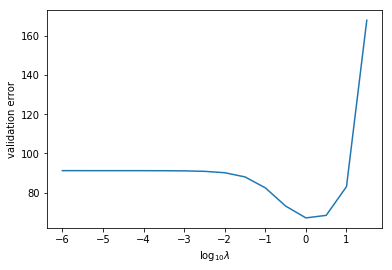

In [42]:
#plot validation error against lambda
plt.plot(lambda_val_lst, val_error)
plt.xlabel('$\log_{10}\lambda$')
plt.ylabel("validation error")
plt.show()

In [43]:
#table of values
df_lambda = pd.DataFrame(np.vstack((lambda_val_lst, val_error)).transpose(), columns = ["lambda value (10^)", "validation error"])
df_lambda

,lambda value (10^),validation error
0,-6.0,91.220809
1,-5.5,91.214366
2,-5.0,91.213619
3,-4.5,91.211285
4,-4.0,91.203904
5,-3.5,91.180578
6,-3.0,91.106946
7,-2.5,90.875421
8,-2.0,90.155156
9,-1.5,88.022245


In [47]:
lambda_val_lst2 = np.arange(0, 5, 0.5, dtype = float)
val_error2 = []
for val in lambda_val_lst2:
    w_ridge_cyc_val = shooting_alg(X_train, y_train, w_ridge, val)
    val_error2.append(400*RMSE(X_val, y_val, w_ridge_cyc_val))

/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


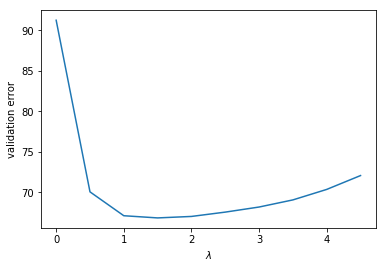

In [48]:
plt.plot(lambda_val_lst2, val_error2)
plt.xlabel('$\lambda$')
plt.ylabel("validation error")
plt.show()

In [49]:
df_lambda2 = pd.DataFrame(np.vstack((lambda_val_lst2, val_error2)).transpose(), columns = ["lambda value", "validation error"])
df_lambda2

,lambda value,validation error
0,0.0,91.225120
1,0.5,70.070037
2,1.0,67.127561
3,1.5,66.858052
4,2.0,67.040125
5,2.5,67.573367
6,3.0,68.200246
7,3.5,69.078354
8,4.0,70.371632
9,4.5,72.079303


/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


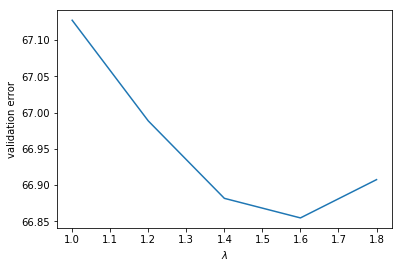

In [50]:
lambda_val_lst3 = np.arange(1, 2, 0.2, dtype = float)
val_error3 = []
for val in lambda_val_lst3:
    w_ridge_cyc_val = shooting_alg(X_train, y_train, w_ridge, val)
    val_error3.append(400*RMSE(X_val, y_val, w_ridge_cyc_val))
plt.plot(lambda_val_lst3, val_error3)
plt.xlabel('$\lambda$')
plt.ylabel("validation error")
plt.show()

In [24]:
best_lambda = 10**df_lambda['lambda value (10^)'][np.argmin(df_lambda['validation error'])]
print("The lambda value here is {}".format(best_lambda))

The lambda value here is 1.0


In [25]:
w_ridge_zero = shooting_alg(X_train, y_train, w_ridge, 0)

/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


In [26]:
def plot_prediction_functions_size(x, pred_fns, x_train, y_train, legend_loc="best"):
    fig, ax = plt.subplots(figsize = (12, 8))
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.scatter(x_train, y_train, label='Training data')
    for i in range(len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
    legend = ax.legend(loc=legend_loc, bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True)
    return fig

In [27]:
def compare_parameter_vectors_size(pred_fns):
    fig, axs = plt.subplots(len(pred_fns),1, sharex=True, figsize = (12, 8))
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = pred_fns[i]["name"]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals)
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].set_title(title)

    fig.subplots_adjust(hspace=0.3)
    return fig

In [28]:


coef = shooting_alg(X_train, y_train, w_ridge, best_lambda)
name = "Lasso with L1Reg="+str(best_lambda)
pred_fns.append({"name":name,
                 "coefs":coef,
                 "preds":np.dot(X, coef) })



/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


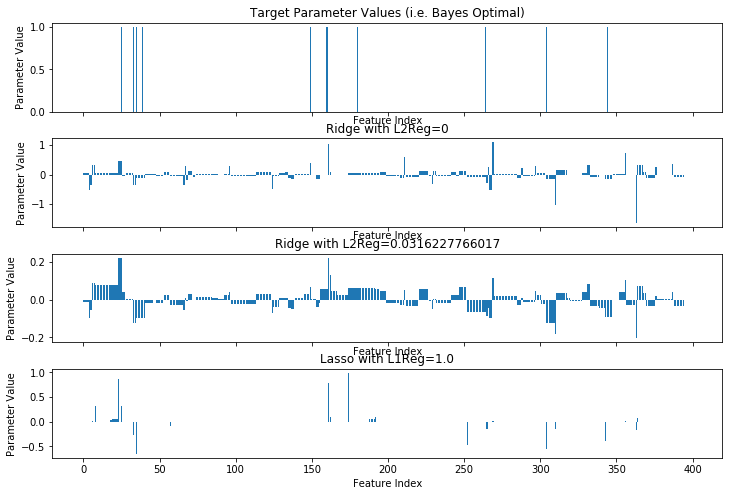

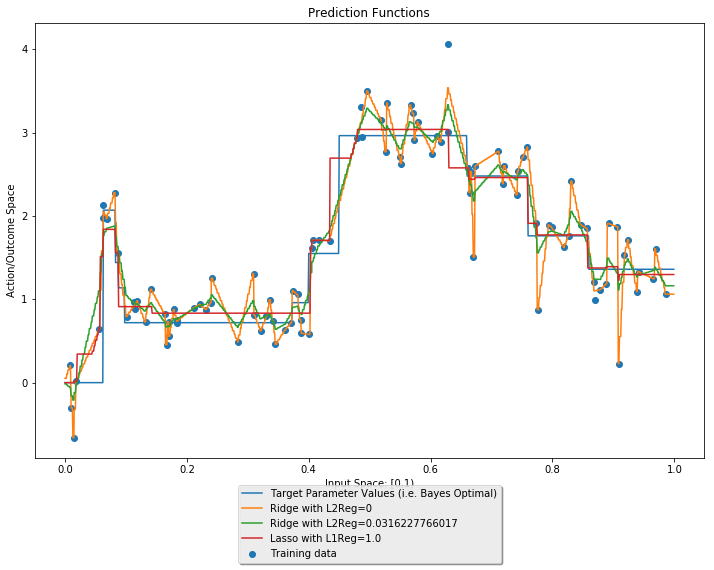

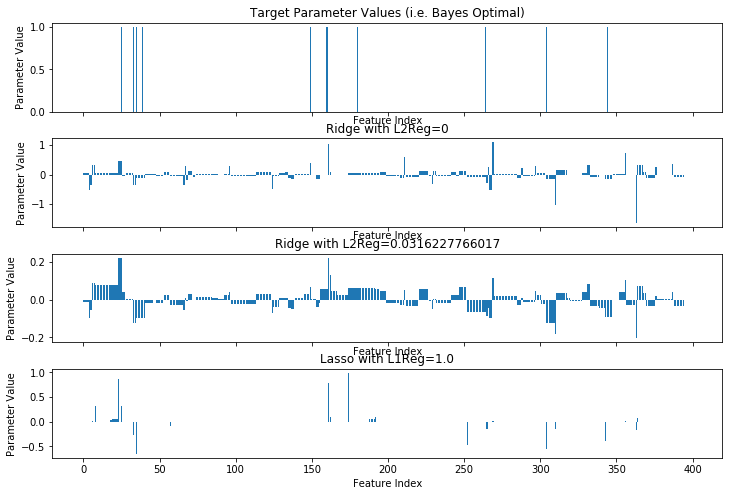

In [29]:
plot_prediction_functions_size(x, pred_fns, x_train, y_train, legend_loc="upper center")
compare_parameter_vectors_size(pred_fns)

In [30]:
pred_fns[-1]['coefs']

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.72003497e-02,   0.00000000e+00,   3.25510162e-01,
         1.94011474e-14,   1.89293026e-14,   2.95692290e-14,
         1.73845313e-14,   5.92408067e-16,   1.48058649e-15,
         1.77635684e-15,   1.48058649e-15,   2.96637714e-16,
         3.58216138e-02,   6.49226740e-02,   6.49226740e-02,
         6.49226740e-02,   6.49226740e-02,   8.74316854e-01,
         1.19695920e-15,   3.26691806e-01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -2.78373795e-01,   0.00000000e+00,  -6.48856195e-01,
         0.00000000e+00,  -3.15719673e-16,  -3.15719673e-16,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [31]:
RMSE(X_val, y_val, pred_fns[-1]['coefs'])

0.14365205085429603

The lasso solutions' coefficients are much more sparse than the ridge ones. With less coefficients, 
lasso solutions are simpler and their performance are not bad compared to ridges as well. But the best model in terms 
of smaller validation error is the ridge regression with l2 regularization coefficient as 0.031623

In [33]:
#3.4
lambda_max = 2*np.linalg.norm(np.dot(X_train.transpose(),y_train), ord = np.inf)
times_idx_list = np.arange(0,30, dtype=float)
validation_loss_homotopy = []
for idx in times_idx_list:
    lambda_homotopy = lambda_max*0.8**idx
    w = shooting_alg(X_train, y_train, w_ridge, lambda_homotopy)
    validation_loss_homotopy.append(RMSE(X_val, y_val, w))


/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


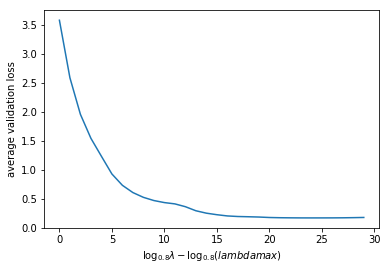

In [36]:
plt.plot(times_idx_list, validation_loss_homotopy)
plt.xlabel('$\log_{0.8}\lambda - \log_{0.8}(lambda max)$')
plt.ylabel("average validation loss")
plt.show()

In [35]:
pd.DataFrame(np.vstack((times_idx_list, validation_loss_homotopy)))

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,1.000000,2.000000,3.00,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,20.000000,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000
1,3.576553,2.584477,1.953811,1.54,1.230747,0.925138,0.729502,0.604258,0.522022,0.466788,...,0.174335,0.170564,0.168636,0.167465,0.167135,0.167408,0.167821,0.169222,0.171695,0.174971
